In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

## 4 Special Moves

In [2]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
#special_probs = {"break": 0.5, "combine": 0.5}
special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

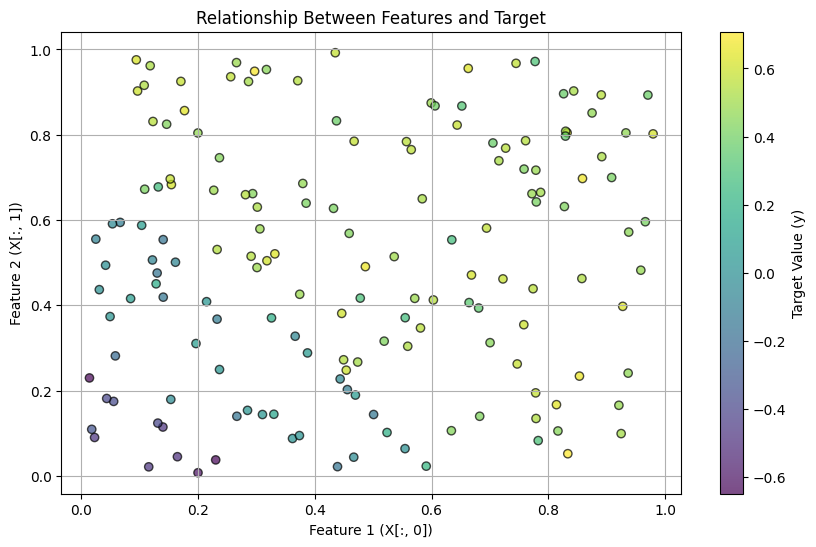

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(scatter, label='Target Value (y)')
plt.title('Relationship Between Features and Target')
plt.xlabel('Feature 1 (X[:, 0])')
plt.ylabel('Feature 2 (X[:, 1])')
plt.grid(True)
plt.show()

In [4]:
bart = ChangeNumTreeBART(ndpost=2000, nskip=2000, n_trees=50, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0 = 50, theta_df = np.inf, 
                         tree_num_prior_type="poisson", special_move_interval=1)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 4000/4000 [00:19<00:00, 206.46it/s]


In [5]:
bart.trace[-1].n_trees

15

In [6]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.00645861]), 'ntree_theta': 50}

In [7]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

25.7025

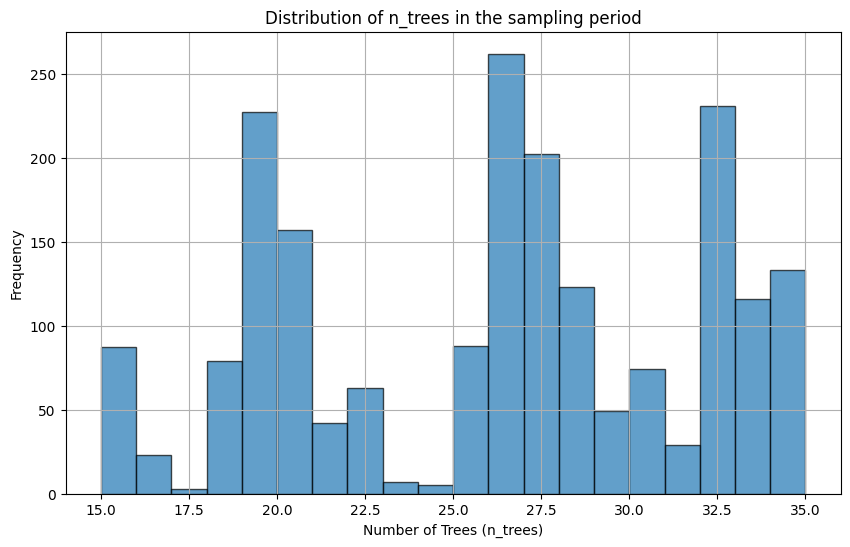

In [8]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

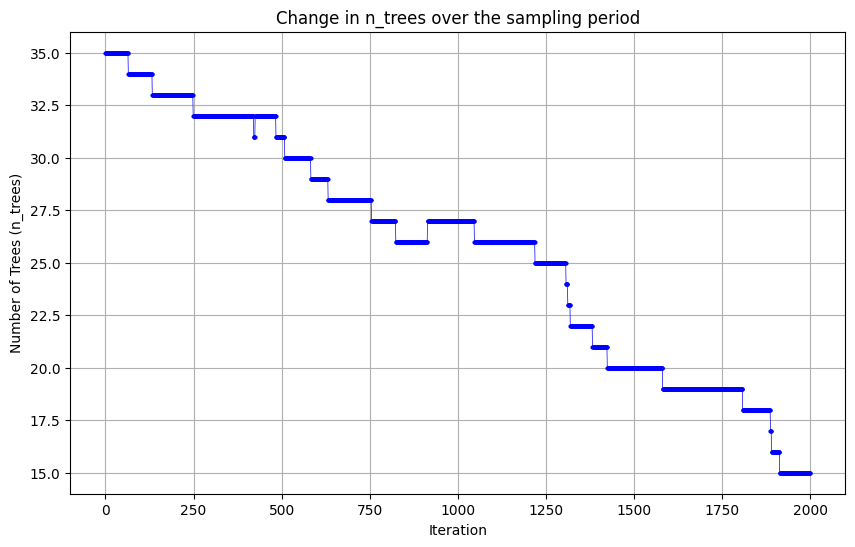

In [9]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [10]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-04-24 00:17:31,679:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-24 00:17:31,684:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.47 P_prune=0.53 A_grow=0.29 A_prune=0.25 (burnin)
Iteration 200/300 P_grow=0.53 P_prune=0.47 A_grow=0.12 A_prune=0.29
Iteration 300/300 P_grow=0.73 P_prune=0.27 A_grow=0.18 A_prune=0.50


In [11]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.02351515920472045,
 'rf': 0.020564251712141372,
 'lr': 0.048045521328019404,
 'btz': 0.025209914831496167}

In [12]:
print(f'Birth move count: {len(bart.sampler.birth_mh_ratios)}; mh median: {np.median(bart.sampler.birth_mh_ratios)}')

Birth move count: 1017; mh median: 0.004932655843565987


In [13]:
print(f'Death move count: {len(bart.sampler.death_mh_ratios)}; mh median: {np.median(bart.sampler.death_mh_ratios)}')

Death move count: 45; mh median: 34.76481062985812


In [14]:
print(f'Break move count: {len(bart.sampler.break_mh_ratios)}; mh median: {np.median(bart.sampler.break_mh_ratios)}')

Break move count: 447; mh median: nan


In [15]:
print(f'Combine move count: {len(bart.sampler.combine_mh_ratios)}; mh median: {np.median(bart.sampler.combine_mh_ratios)}')

Combine move count: 788; mh median: nan


In [16]:
bart.trace[-1].trees

[Tree(vars=[ 1  0 -1 -1 -1 -2 -2 -2], thresholds=[0.2435121  0.55914191        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan         nan  0.03784134 -0.12551889  0.08322373         nan
          nan         nan], n_vals=[120  28  92  19   9  -2  -2  -2]),
 Tree(vars=[-1 -2], thresholds=[nan nan], leaf_vals=[0.05843002        nan], n_vals=[120  -2]),
 Tree(vars=[ 1  0 -1  1 -1 -2 -2 -1 -1 -2 -2 -2 -2 -2 -2 -2], thresholds=[0.63752152 0.55474272        nan 0.1162583         nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan], leaf_vals=[        nan         nan -0.04049147         nan  0.01580503         nan
          nan -0.03063556 -0.03707835         nan         nan         nan
          nan         nan         nan         nan], n_vals=[120  74  46  51  23  -2  -2  11  40  -2  -2  -2  -2  -2  -2  -2]),
 Tree(vars=[ 1 -1 -1 -2], thresholds=[0.2435121       nan       nan 

In [17]:
X_sample = X_test[1].reshape(1, -1)
X_sample

array([[0.13105775, 0.1237538 ]])

In [18]:
y_test[1]

-0.39107825032892074

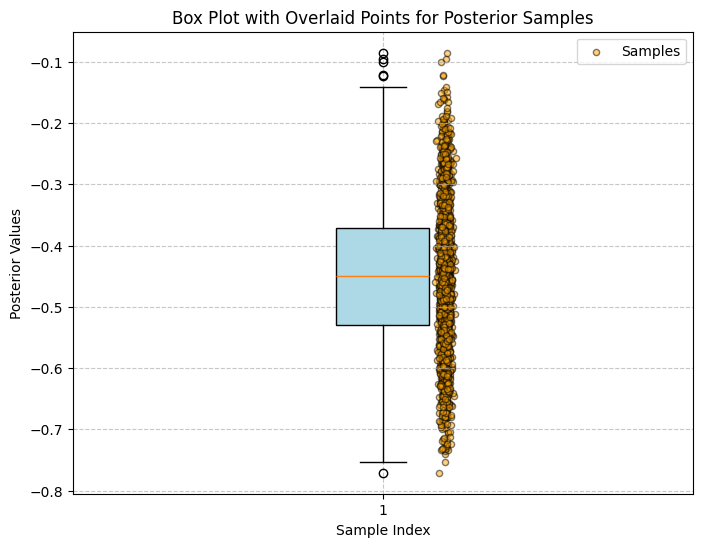

In [19]:
import matplotlib.pyplot as plt
import numpy as np

posterior_values = bart.posterior_f(X_sample)

plt.figure(figsize=(8, 6))
plt.boxplot(posterior_values[0], vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
for i in range(posterior_values.shape[1]):
    y = posterior_values[:, i]
    x = np.random.normal(1.1, 0.005, size=len(y))
    plt.scatter(x, y, alpha=0.5, color='orange', edgecolor='k', s=20, label='Samples' if i == 0 else None)

plt.title('Box Plot with Overlaid Points for Posterior Samples')
plt.ylabel('Posterior Values')
plt.xlabel('Sample Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [20]:
eval_single = [float(bart.trace[-1].trees[i].evaluate(X_sample)) for i in range(len(bart.trace[-1].trees))]
eval_single

[-0.12551889474682715,
 0.05843001893258572,
 -0.03707835288530472,
 -0.0667483381255343,
 0.07724139853692505,
 -0.06709711750591063,
 0.06495530741814473,
 -0.06357673502600643,
 -0.020148745597715435,
 0.035043455595556314,
 -0.003385506385890018,
 -0.10193029144737337,
 -0.10148354906051132,
 -0.05650369990003103,
 -0.0815923508505018]

In [21]:
len(eval_single)

15

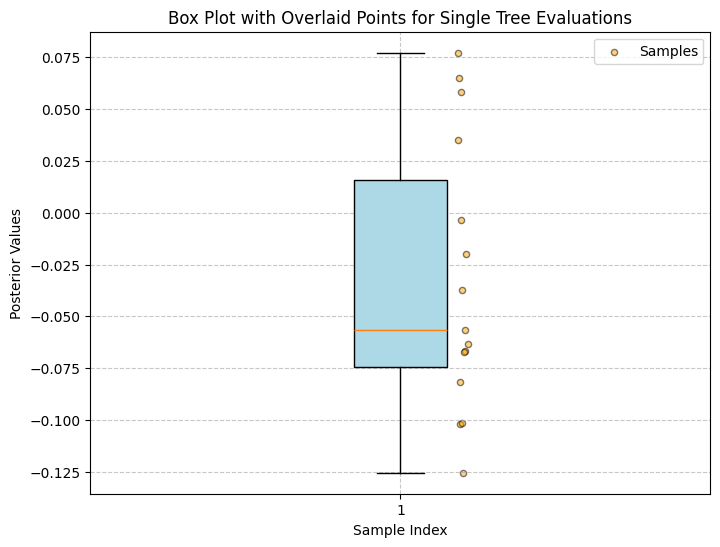

In [22]:
plt.figure(figsize=(8, 6))
plt.boxplot(eval_single, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
for i in range(len(eval_single)):
    y = eval_single[i]
    x = np.random.normal(1.1, 0.005, size=1)
    plt.scatter(x, y, alpha=0.5, color='orange', edgecolor='k', s=20, label='Samples' if i == 0 else None)

plt.title('Box Plot with Overlaid Points for Single Tree Evaluations')
plt.ylabel('Posterior Values')
plt.xlabel('Sample Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [23]:
np.var(eval_single)

0.003996383143396331

In [24]:
np.sum(eval_single)

-0.4893934010483944

In [25]:
eval = [bart.trace[i].evaluate(X_sample) for i in range(len(bart.trace))]
eval

[array([-0.50550218]),
 array([-0.49323202]),
 array([-0.47693752]),
 array([-0.47530889]),
 array([-0.49267477]),
 array([-0.46985709]),
 array([-0.50837662]),
 array([-0.47129912]),
 array([-0.44097069]),
 array([-0.44182182]),
 array([-0.46585773]),
 array([-0.47208095]),
 array([-0.46642397]),
 array([-0.45818572]),
 array([-0.47776111]),
 array([-0.51014394]),
 array([-0.52324916]),
 array([-0.49216522]),
 array([-0.52390866]),
 array([-0.52982048]),
 array([-0.51826284]),
 array([-0.52734232]),
 array([-0.52688952]),
 array([-0.49310415]),
 array([-0.48674897]),
 array([-0.52012692]),
 array([-0.4616196]),
 array([-0.56847188]),
 array([-0.56028582]),
 array([-0.47164274]),
 array([-0.46654831]),
 array([-0.47579995]),
 array([-0.50689625]),
 array([-0.49255262]),
 array([-0.49304603]),
 array([-0.54316384]),
 array([-0.5415164]),
 array([-0.44820357]),
 array([-0.50583586]),
 array([-0.49536297]),
 array([-0.48247573]),
 array([-0.42098352]),
 array([-0.47972068]),
 array([-0.50

In [26]:
np.mean(eval)

-0.35321075761574

In [27]:
y_test

array([ 0.57494339, -0.39107825,  0.03833771, -0.10585361,  0.58205285,
       -0.46879905, -0.12964723,  0.48524713,  0.30069396,  0.48688625,
        0.49330468,  0.4528224 ,  0.5750869 ,  0.55541165,  0.43010696,
        0.6155312 ,  0.44660998,  0.51601906,  0.48824578,  0.18206462,
        0.37483528, -0.15720403,  0.57823503,  0.43025762,  0.56087615,
        0.49741372, -0.02658388,  0.4874991 ,  0.04278904, -0.06782644,
       -0.03427862,  0.54396366,  0.52023062, -0.14805365,  0.61774119,
        0.54746971,  0.58137637, -0.46316434,  0.29964777,  0.55300647])

In [28]:
btpred

array([ 0.3902641 , -0.29264534, -0.1813702 ,  0.17513628,  0.65540266,
       -0.30422458,  0.20469765,  0.6064883 ,  0.5767761 ,  0.45255977,
        0.41597912,  0.5971877 ,  0.5802726 ,  0.35262948,  0.41219455,
        0.47559938,  0.53107446,  0.5256804 ,  0.452077  ,  0.42396215,
        0.5122923 ,  0.09392095,  0.5568446 ,  0.47885993,  0.51140416,
        0.54158807, -0.26564157,  0.46062416,  0.07340271,  0.12190197,
       -0.00957188,  0.20764595,  0.41598415,  0.02878333,  0.52795374,
        0.43144664,  0.41433555, -0.39937583,  0.5243602 ,  0.5053315 ],
      dtype=float32)

In [29]:
y_pred = bart.predict(X_test)
y_pred

array([ 0.47197399, -0.44918457,  0.15674035,  0.09549518,  0.59208204,
       -0.45359459,  0.13144191,  0.66561156,  0.69970551,  0.42320894,
        0.52010203,  0.69248817,  0.70129507,  0.36622398,  0.34472027,
        0.49177741,  0.52203835,  0.68517049,  0.55995678,  0.22811942,
        0.63598915,  0.07330961,  0.49236332,  0.54591606,  0.56363333,
        0.49625207, -0.442526  ,  0.48217019, -0.03628905,  0.0741288 ,
        0.03374643,  0.49084481,  0.489043  ,  0.00261975,  0.61346851,
        0.42262532,  0.50810834, -0.5477112 ,  0.4666096 ,  0.62415538])